In [1]:
#My dataset is available in googledrive; so I am accessing my drive from colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#Once this is executed, you will see your drive appearing on the left hand side

Mounted at /content/drive


In [4]:
# Define paths to the dataset
train_dir = '//content/drive/MyDrive/train-cat-rabbit'  # Update with your actual path
test_dir = '//content/drive/MyDrive/test-images'    # Update with your actual path

In [5]:
import os
print(len(os.listdir('//content/drive/MyDrive/train-cat-rabbit/cat')))
print(len(os.listdir('//content/drive/MyDrive/train-cat-rabbit/rabbit')))
print(len(os.listdir('//content/drive/MyDrive/test-images/cat')))
print(len(os.listdir('//content/drive/MyDrive/test-images/rabbit')))

800
800
10
5


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% of the images for validation
)

# Load and prepare training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',  # 'binary' for binary classification (cats vs. rabbits)
    subset='training'  # Specify 'training' for the training set
)

# Create ImageDataGenerator for validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Note: Using the same validation split as in the training set
)

# Load and prepare validation data
validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify 'validation' for the validation set
)

Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [7]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,UpSampling2D, Dropout

In [8]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))  # 32 filters
#model.add(BatchNormalization())  # added to reduce overfitting
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
#model.add(BatchNormalization())  # added to reduce overfitting
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
#model.add(BatchNormalization())  # added to reduce overfitting
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu')) #feature reduction
#model.add(Dropout(0.1))  # added to reduce overfitting
model.add(Dense(64,activation='relu'))
#model.add(Dropout(0.1))  # added to reduce overfitting
model.add(Dense(1,activation='sigmoid'))  #output layer

In [10]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy']) #binary_crossentropy - binary classification

In [11]:
history = model.fit(train_data, epochs=30, validation_data=validation_data)

Epoch 1/30
40/40 [==============================] - 491s 12s/step - loss: 0.7074 - accuracy: 0.6133 - val_loss: 0.6176 - val_accuracy: 0.6812
Epoch 2/30
40/40 [==============================] - 224s 6s/step - loss: 0.5303 - accuracy: 0.7422 - val_loss: 0.4519 - val_accuracy: 0.8031
Epoch 3/30
40/40 [==============================] - 216s 5s/step - loss: 0.3528 - accuracy: 0.8477 - val_loss: 0.3641 - val_accuracy: 0.8156
Epoch 4/30
40/40 [==============================] - 218s 5s/step - loss: 0.2249 - accuracy: 0.9039 - val_loss: 0.2828 - val_accuracy: 0.8813
Epoch 5/30
40/40 [==============================] - 227s 6s/step - loss: 0.1348 - accuracy: 0.9570 - val_loss: 0.3468 - val_accuracy: 0.8719
Epoch 6/30
40/40 [==============================] - 214s 5s/step - loss: 0.1283 - accuracy: 0.9469 - val_loss: 0.3296 - val_accuracy: 0.8687
Epoch 7/30
40/40 [==============================] - 214s 5s/step - loss: 0.0547 - accuracy: 0.9781 - val_loss: 0.3622 - val_accuracy: 0.9000
Epoch 8/30
4

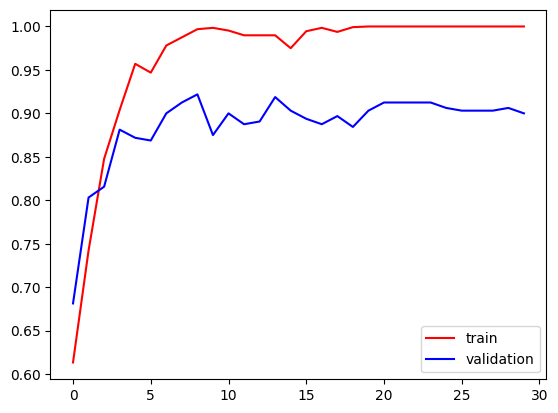

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

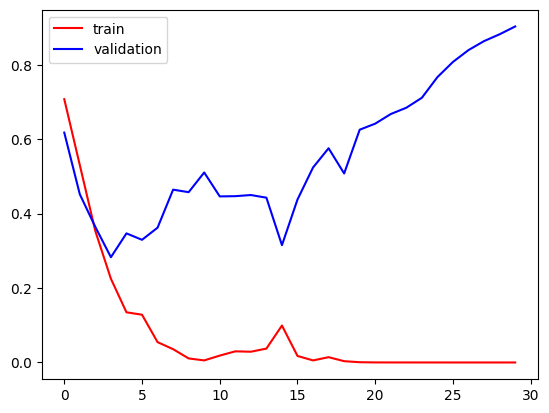

In [13]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

Found 15 images belonging to 2 classes.


In [15]:
#predict the test data
predictions = model.predict(test_data)
print(predictions)

1/1 [==============================] - 1s 821ms/step
[[2.2814955e-11]
 [2.9415696e-07]
 [1.7109900e-13]
 [4.0763147e-15]
 [1.0000000e+00]
 [1.6669264e-17]
 [9.2641747e-04]
 [5.4512913e-03]
 [6.2184459e-12]
 [1.0539121e-08]
 [5.2199174e-14]
 [8.3019799e-03]
 [9.9999642e-01]
 [8.7498164e-01]
 [9.9999571e-01]]


In [16]:
len(predictions)

15

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have ground truth labels (true_labels) and predicted labels (predictions)
true_labels = test_data.classes
predicted_labels = (predictions > 0.5).astype(int)  # Adjust the threshold as needed

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Confusion Matrix:
[[9 1]
 [2 3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.75      0.60      0.67         5

    accuracy                           0.80        15
   macro avg       0.78      0.75      0.76        15
weighted avg       0.80      0.80      0.79        15



In [18]:
#My dataset is available in googledrive; so I am accessing my drive from colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#Once this is executed, you will see your drive appearing on the left hand side

Mounted at /content/drive


In [19]:
# Define paths to the dataset
train_dir = '//content/drive/MyDrive/train-cat-rabbit'  # Update with your actual path
test_dir = '//content/drive/MyDrive/test-images'    # Update with your actual path

In [20]:
import os
print(len(os.listdir('//content/drive/MyDrive/train-cat-rabbit/cat')))
print(len(os.listdir('//content/drive/MyDrive/train-cat-rabbit/rabbit')))
print(len(os.listdir('//content/drive/MyDrive/test-images/cat')))
print(len(os.listdir('//content/drive/MyDrive/test-images/rabbit')))

800
800
10
5


In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% of the images for validation
)

# Load and prepare training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',  # 'binary' for binary classification (cats vs. dogs)
    subset='training'  # Specify 'training' for the training set
)

# Create ImageDataGenerator for validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Note: Using the same validation split as in the training set
)

# Load and prepare validation data
validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify 'validation' for the validation set
)

Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [22]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

resnet_model = Sequential()    #ResNet50 is a pre-trained model
pretrained_model = tf.keras.applications.ResNet50(include_top = False, #because i have my own image of a diff dimension
                                                input_shape = (256,256,3),
                                                pooling = 'max', classes = 2,
                                                weights = 'imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False  #all layers in the Resnet50 is not trainable; keep those weights; I am going to add my own i/p and other layers

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation = 'relu'))
resnet_model.add(Dense(1, activation = 'sigmoid'))

94765736/94765736 [==============================] - 1s 0us/step


In [23]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [25]:
from keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy']) #binary_crossentropy - binary classification

In [26]:
history = resnet_model.fit(train_data, epochs=3, validation_data=validation_data)

Epoch 1/3
40/40 [==============================] - 524s 13s/step - loss: 1.7951 - accuracy: 0.5289 - val_loss: 0.6431 - val_accuracy: 0.6344
Epoch 2/3
40/40 [==============================] - 514s 13s/step - loss: 0.6620 - accuracy: 0.6148 - val_loss: 0.6069 - val_accuracy: 0.6344
Epoch 3/3
40/40 [==============================] - 467s 12s/step - loss: 0.6391 - accuracy: 0.6500 - val_loss: 0.5911 - val_accuracy: 0.6469


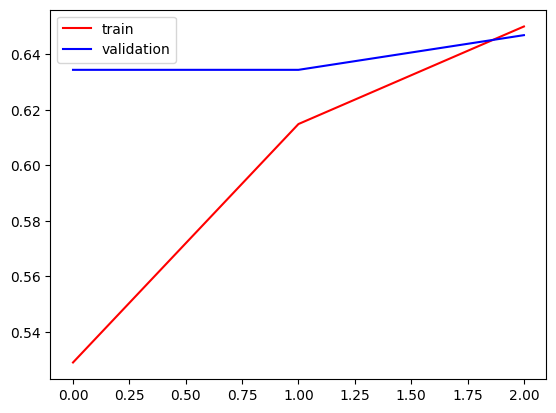

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

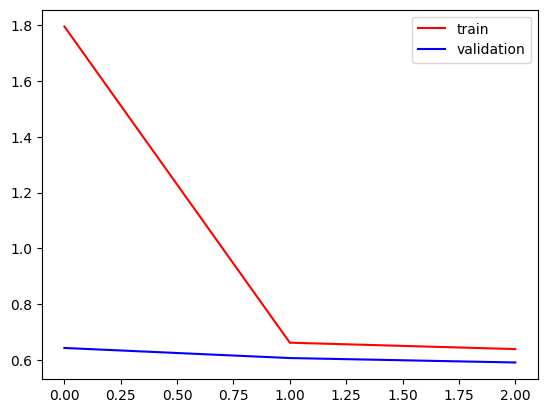

In [28]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [29]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

Found 15 images belonging to 2 classes.


In [30]:
#predict the test data
predictions = resnet_model.predict(test_data)
print(predictions)

1/1 [==============================] - 5s 5s/step
[[0.39565745]
 [0.18628736]
 [0.72913325]
 [0.53094596]
 [0.3009688 ]
 [0.1877957 ]
 [0.5069696 ]
 [0.21034844]
 [0.28867483]
 [0.14596692]
 [0.32438934]
 [0.18865421]
 [0.21922271]
 [0.88978726]
 [0.4741578 ]]


In [31]:
len(predictions)

15

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have ground truth labels (true_labels) and predicted labels (predictions)
true_labels = test_data.classes
predicted_labels = (predictions > 0.5).astype(int)  # Adjust the threshold as needed

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Confusion Matrix:
[[7 3]
 [4 1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.25      0.20      0.22         5

    accuracy                           0.53        15
   macro avg       0.44      0.45      0.44        15
weighted avg       0.51      0.53      0.52        15

